In [1]:
import numpy as np

import matplotlib.pyplot as plt

from models import Naive, HoltWinters, SARIMA, LSTM
from utils import get_data, get_stationary_data

from sklearn.metrics import mean_squared_error

import time

YEAR_CUTOFFS = [1940, 1956, 1960]

In [2]:
df, train, val, test = get_data(YEAR_CUTOFFS)
df_sta, train_sta, val_sta, test_sta = get_stationary_data(YEAR_CUTOFFS)

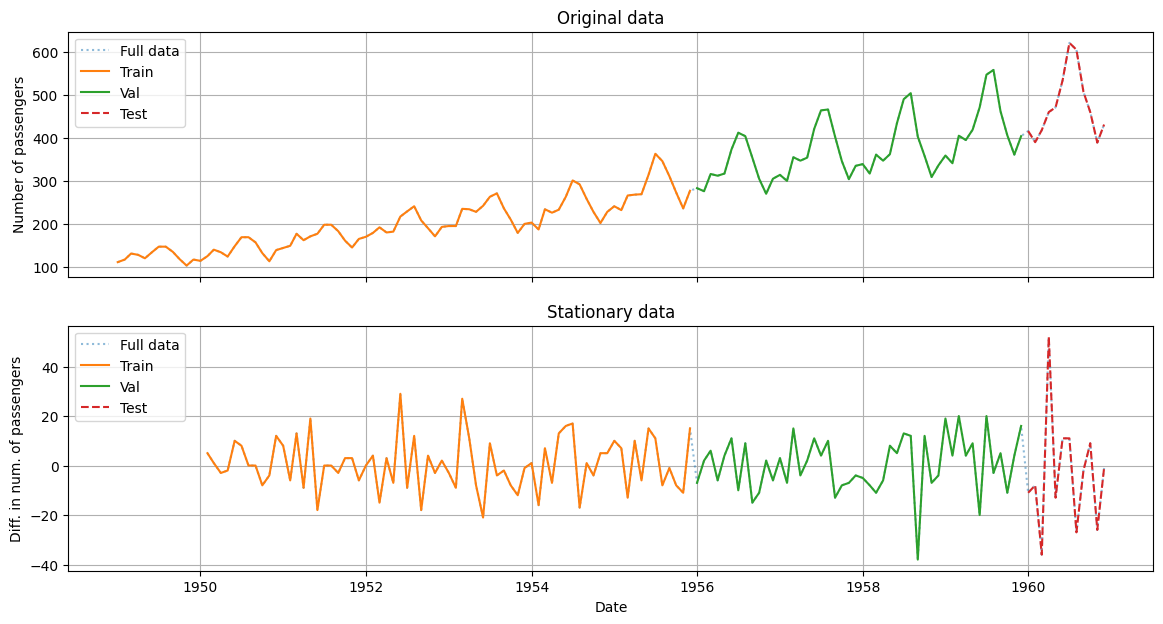

In [3]:
fig, axs = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axs[0].set_title("Original data")
axs[0].set_ylabel("Number of passengers")

axs[0].plot(
    df["Date"], df["Passengers"], alpha=0.5, linestyle="dotted", label="Full data"
)
axs[0].plot(train["Date"], train["Passengers"], label="Train")
axs[0].plot(val["Date"], val["Passengers"], label="Val")
axs[0].plot(test["Date"], test["Passengers"], linestyle="dashed", label="Test")

axs[0].grid()
axs[0].legend()

axs[1].set_title("Stationary data")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Diff. in num. of passengers")

axs[1].plot(
    df_sta["Date"],
    df_sta["Passengers"],
    alpha=0.5,
    linestyle="dotted",
    label="Full data",
)
axs[1].plot(train_sta["Date"], train_sta["Passengers"], label="Train")
axs[1].plot(val_sta["Date"], val_sta["Passengers"], label="Val")
axs[1].plot(test_sta["Date"], test_sta["Passengers"], linestyle="dashed", label="Test")

axs[1].grid()
axs[1].legend()

plt.show()

In [4]:
models = {
    "Naive": {
        "model": Naive(train, val),
        "stationary": False,
    },
    "HoltWinters": {
        "model": HoltWinters(train, val),
        "stationary": False,
    },
    "SARIMA": {
        "model": SARIMA(train, val, (0, 1, 0), (0, 1, 0, 12)),
        "stationary": False,
    },
    "LSTM": {
        "model": LSTM(train, val, n_epochs=2500),
        "stationary": False,
    },
}

In [5]:
for model_name in models:
    t1 = time.time()
    model_dict = models[model_name]
    model = model_dict["model"]
    model.train_model()
    t2 = time.time()
    print(f"Model {model_name} trained in {(t2 - t1)/60:.2f} min.")
    pred = model.predict()
    model_dict["pred"] = pred
    model_dict["metrics"] = model.get_metrics(val, pred)

Model Naive trained in 0.00 min.
Model HoltWinters trained in 0.00 min.
Model SARIMA trained in 0.00 min.
Model LSTM trained in 3.24 min.


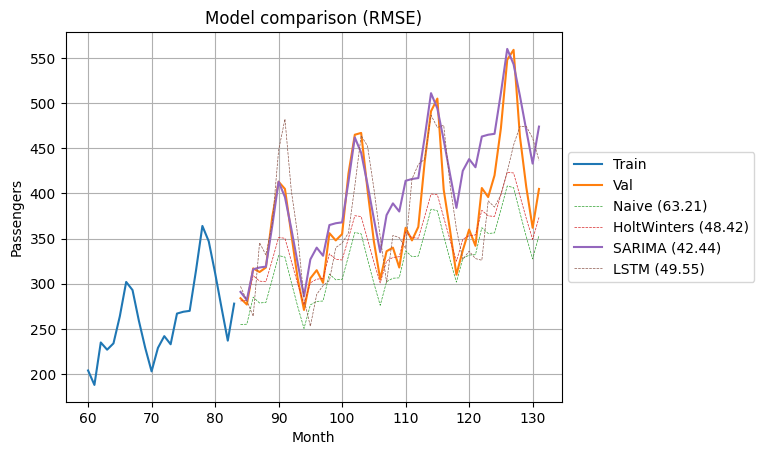

In [6]:
plt.title("Model comparison (RMSE)")

plt.xlabel("Month")
plt.ylabel("Passengers")

plt.plot(train["Passengers"][-24:], label="Train")
plt.plot(val["Passengers"], label="Val")

for model_name in models:
    if not models[model_name]["stationary"]:
        pred = models[model_name]["pred"]
        rmse = models[model_name]["metrics"]["RMSE"]
        kwargs = {"linewidth": 0.5, "linestyle": "dashed"} if rmse > 45 else {}
        plt.plot(val.index, pred, label=f"{model_name} ({rmse:.2f})", **kwargs)

plt.grid()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

While the SARIMA fits the validation set better in the first 2 years, the LSTM is more accurate in the last 2 years.

In [7]:
val["SARIMA"] = models["SARIMA"]["pred"]
val["LSTM"] = models["LSTM"]["pred"]
val.head()

,Passengers,Date,Month,res,res_scal,SARIMA,LSTM
84,284,1956-01-01,84,-9.607937,0.243663,291.0,297.116065
85,277,1956-02-01,85,-19.002660,0.202358,282.0,281.265263
86,317,1956-03-01,86,18.602617,0.367694,316.0,264.034054
87,313,1956-04-01,87,12.207894,0.339579,318.0,345.461716
88,318,1956-05-01,88,14.813170,0.351034,319.0,331.954543


In [8]:
val["SARIMA_SE"] = (val["Passengers"] - val["SARIMA"]) ** 2
val["LSTM_SE"] = (val["Passengers"] - val["LSTM"]) ** 2
val.head()

,Passengers,Date,Month,res,res_scal,SARIMA,LSTM,SARIMA_SE,LSTM_SE
84,284,1956-01-01,84,-9.607937,0.243663,291.0,297.116065,49.0,172.031171
85,277,1956-02-01,85,-19.002660,0.202358,282.0,281.265263,25.0,18.192469
86,317,1956-03-01,86,18.602617,0.367694,316.0,264.034054,1.0,2805.391462
87,313,1956-04-01,87,12.207894,0.339579,318.0,345.461716,25.0,1053.762981
88,318,1956-05-01,88,14.813170,0.351034,319.0,331.954543,1.0,194.729278


In [9]:
val["Year"] = val["Date"].apply(lambda d: d.year)
val_year = val[["Year", "SARIMA_SE", "LSTM_SE"]].groupby("Year").mean()
val_year.columns = ["SARIMA_MSE", "LSTM_MSE"]
val_year

,SARIMA_MSE,LSTM_MSE
Year,,
1956,106.083333,1592.240160
1957,489.250000,1700.023021
1958,3152.333333,1878.137351
1959,3458.000000,4649.497661
